# Attempt 2:
## Target: 
Try to reduce parameters while achieving same or beter accuracy i.e. above 99.11% test accuracy.

## Results:
Parameters: 4706
Train Accuracy: 98.24%
Test Accuracy: 99.31%


## Analysis
Since the train accuracy is low, we will need to improve the capacity of the model and possibly look at different values of dropout, learning rate & LR Scheduler values. 

# Import Libraries

In [ ]:
# importing all the Python Packages & torch Library.
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Define Data Transformations & Dataset for Train/Test

In [ ]:
train_transforms = transforms.Compose([
                        transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                        # transforms.RandomErasing(),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Train / Test Dataloaders

In [ ]:
# seed the model to obtain consistent results
torch.manual_seed(1)
# this is the batch size , in 1 pas no of images passed together.
batch_size = 64
use_cuda = torch.cuda.is_available()

print("CUDA Available?", use_cuda)

# kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)



# load the training data and perform standard normalization 
# parameter for normalization is mean and std dev.
# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias = True), # output 26X26X4 : RF- 3X3
            nn.ReLU(),
            nn.BatchNorm2d(4), # Batch Normalization after each convolution.
            nn.Dropout2d(0.05), # dropout of 5% at each layer
            
            nn.Conv2d(4, 8, 3), # output 24X24X8 : RF- 5x5
            nn.ReLU(),
            nn.BatchNorm2d(8),  # Batch Normalization after each convolution.
            nn.Dropout2d(0.05),  # dropout of 5% at each layer

            nn.Conv2d(8, 8, 3), # output 22X22X8 : RF- 7X7
            nn.ReLU(),
            nn.BatchNorm2d(8),  # Batch Normalization after each convolution.
            nn.Dropout2d(0.05),  # dropout of 5% at each layer

            nn.MaxPool2d(2, 2)       # output 11X11X8 : RF- 8x8
            )
        self.conv2 = nn.Sequential(
            
           
            nn.Conv2d(8, 16, 3), # output 9X9X16 : RF- 12x12
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.05), # 5% dropout

            nn.Conv2d(16, 8, 3), # output 7X7X8 : RF- 16X16
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.05), # 5% dropout

            )
        self.conv3 = nn.Sequential(
           
            nn.Conv2d(8, 16, 3,padding=1), # output 07X07X16 : RF- 20 X 20
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.05), # 5% dropout

            nn.Conv2d(16, 10, 1), # output 07X07X10 : RF- 20x20
            nn.AvgPool2d(5) # output 1x1x10 : RF- 28x28

            )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x= self.conv2(x)
        x= self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, -1)

# Print Summary of Model

In [ ]:
!pip install torchsummary
from torchsummary import summary
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
       BatchNorm2d-3            [-1, 4, 26, 26]               8
         Dropout2d-4            [-1, 4, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             296
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
         Dropout2d-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 22, 22]             584
             ReLU-10            [-1, 8, 22, 22]               0
      BatchNorm2d-11            [-1, 8, 22, 22]              16
        Dropout2d-12            [-1, 8, 22, 22]               0
        MaxPool2d-13            [-1, 8, 11, 11]               0
           Conv2d-14             [-1, 1

# Define Train and Test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Function to train 
'''
Args: 
Model : created model to be used for training
device : GPU or cpu
train_laoded: data on which the training has to be done
Optimizer : the optimization algorithm to be used
epoch : no fo epoch 

'''
def train(model, device, train_loader, optimizer, epoch):
    model.train() # Set the model on training mode
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device) # moving the data to device
        optimizer.zero_grad() # zero the graidents 
        output = model(data) # getting the model output
        loss = F.nll_loss(output, target) # calculating the The negative log likelihood loss
        train_losses.append(loss)
        loss.backward() # flowing the gradients backward.
        optimizer.step() # paameter updated basd on the current gradient.
        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)        
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

# Function to test 
'''
Args: 
Model : created model to be used for training
device : GPU or cpu
test_laoded: data on which the testing has to be done
 

'''
def test(model, device, test_loader):
    model.eval() # seting up the model for evalaution.
    test_loss = 0 # setting the test loss to 0
    correct = 0 # countign the no of coorect classfication.
    with torch.no_grad(): # turn off gradients, since we are in test mode
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)   # copy the data to device.
            output = model(data) # predict the output
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset) # calculating hte test loss.
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

# Run the model

In [ ]:
from torch.optim.lr_scheduler import StepLR


model = Net().to(device) # move the model to device.
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)  # intiating the SGD optimizer
scheduler = StepLR(optimizer, step_size=4, gamma=0.5)


for epoch in range(1, 16):
    print("epoch =", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)
    

  0%|          | 0/938 [00:00<?, ?it/s]

epoch = 1


loss=0.25298911333084106 batch_id=937 Train Accuracy=90.64: 100%|██████████| 938/938 [00:19<00:00, 47.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0715, Test Accuracy: 9781/10000 (97.81%)

epoch = 2


loss=0.1068246066570282 batch_id=937 Train Accuracy=96.16: 100%|██████████| 938/938 [00:19<00:00, 48.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Test Accuracy: 9826/10000 (98.26%)

epoch = 3


loss=0.00401669554412365 batch_id=937 Train Accuracy=96.75: 100%|██████████| 938/938 [00:19<00:00, 48.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Test Accuracy: 9870/10000 (98.70%)

epoch = 4


loss=0.09400369226932526 batch_id=937 Train Accuracy=96.97: 100%|██████████| 938/938 [00:19<00:00, 48.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Test Accuracy: 9879/10000 (98.79%)

epoch = 5


loss=0.10407747328281403 batch_id=937 Train Accuracy=97.55: 100%|██████████| 938/938 [00:19<00:00, 48.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Test Accuracy: 9901/10000 (99.01%)

epoch = 6


loss=0.007718962151557207 batch_id=937 Train Accuracy=97.77: 100%|██████████| 938/938 [00:19<00:00, 49.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Test Accuracy: 9904/10000 (99.04%)

epoch = 7


loss=0.03251846507191658 batch_id=937 Train Accuracy=97.73: 100%|██████████| 938/938 [00:19<00:00, 49.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Test Accuracy: 9913/10000 (99.13%)

epoch = 8


loss=0.0651790201663971 batch_id=937 Train Accuracy=97.73: 100%|██████████| 938/938 [00:19<00:00, 48.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Test Accuracy: 9904/10000 (99.04%)

epoch = 9


loss=0.10725719481706619 batch_id=937 Train Accuracy=98.01: 100%|██████████| 938/938 [00:19<00:00, 48.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Test Accuracy: 9925/10000 (99.25%)

epoch = 10


loss=0.016243018209934235 batch_id=937 Train Accuracy=98.00: 100%|██████████| 938/938 [00:19<00:00, 48.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Test Accuracy: 9921/10000 (99.21%)

epoch = 11


loss=0.04518852010369301 batch_id=937 Train Accuracy=98.00: 100%|██████████| 938/938 [00:18<00:00, 49.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Test Accuracy: 9921/10000 (99.21%)

epoch = 12


loss=0.058990322053432465 batch_id=937 Train Accuracy=98.03: 100%|██████████| 938/938 [00:19<00:00, 48.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Test Accuracy: 9913/10000 (99.13%)

epoch = 13


loss=0.040310390293598175 batch_id=937 Train Accuracy=98.19: 100%|██████████| 938/938 [00:19<00:00, 48.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Test Accuracy: 9927/10000 (99.27%)

epoch = 14


loss=0.0125196548178792 batch_id=937 Train Accuracy=98.24: 100%|██████████| 938/938 [00:19<00:00, 48.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Test Accuracy: 9926/10000 (99.26%)

epoch = 15


loss=0.029057037085294724 batch_id=937 Train Accuracy=98.12: 100%|██████████| 938/938 [00:19<00:00, 48.32it/s]



Test set: Average loss: 0.0244, Test Accuracy: 9931/10000 (99.31%)



Text(0.5, 1.0, 'Test Accuracy')

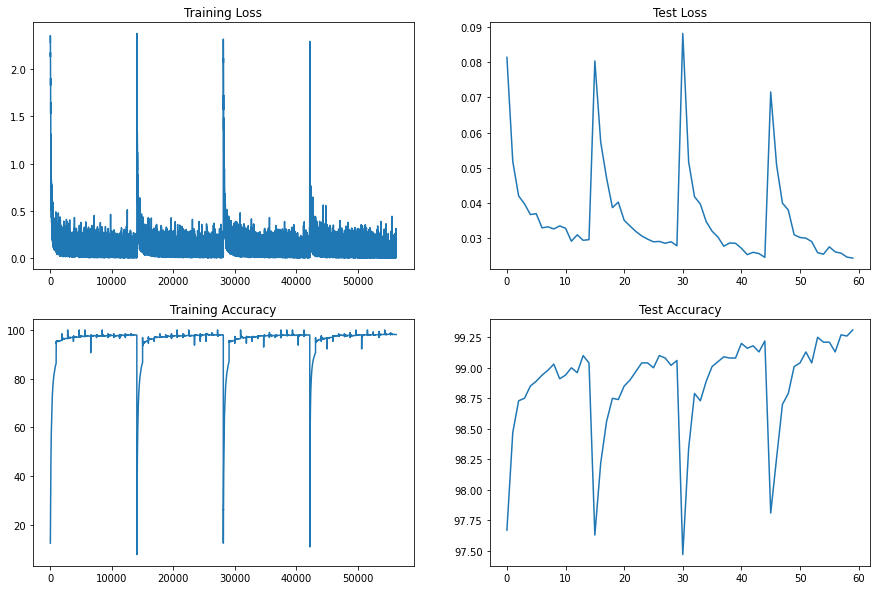

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")